# Plots for logistic regression, increasing noise levels for unregularized consistent AT

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dotenv
import pandas as pd
import mlflow
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots
import plotly.io as pio

import typing
import os
import shutil
import sys
import warnings

In [2]:
EXPORT = False
SHOW_TITLES = not EXPORT
EXPERIMENT_NAME = 'logistic_regression_noise_increase'

In [3]:
# Load environment variables
dotenv.load_dotenv()

# Enable loading of the project module
MODULE_DIR = os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, os.pardir)), 'src')
sys.path.append(MODULE_DIR)

In [4]:
%load_ext autoreload
%autoreload 2
import interpolation_robustness as ir

In [5]:
FIGURE_SIZE = (2.6, 2.0)
LEGEND_FONT_SIZE = ir.plots.FONT_SIZE_SMALL_PT

ir.plots.setup_matplotlib(show_titles=SHOW_TITLES)

In [6]:
if EXPORT:
    EXPORT_DIR = os.path.join(ir.util.REPO_ROOT_DIR, 'logs', f'export_{EXPERIMENT_NAME}')
    print('Using export directory', EXPORT_DIR)
    if os.path.exists(EXPORT_DIR):
        shutil.rmtree(EXPORT_DIR)
    os.makedirs(EXPORT_DIR)

def export_fig(fig: plt.Figure, filename: str):
    # If export is disabled then do nothing
    if EXPORT:
        export_path = os.path.join(EXPORT_DIR, filename)
        fig.savefig(export_path)
        print('Exported figure at', export_path)


## Load experiment data

In [7]:
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name(EXPERIMENT_NAME)
runs = mlflow.search_runs(
    experiment.experiment_id
)
runs = runs.set_index('run_id', drop=False)  # set index, but keep column to not break stuff depending on it

# Convert some parameters to numbers and sort accordingly
runs['params.data_dim'] = runs['params.data_dim'].astype(int)
runs['params.train_attack_epsilon'] = runs['params.train_attack_epsilon'].astype(np.float)
runs['params.test_attack_epsilon'] = runs['params.test_attack_epsilon'].astype(np.float)
runs['params.l2_lambda'] = runs['params.l2_lambda'].astype(np.float)
runs['params.label_noise'] = runs['params.label_noise'].astype(np.float)
runs['metrics.train_robust_risk'] = 1.0 - runs['metrics.train_robust_accuracy']
runs = runs.sort_values(['params.label_noise'], ascending=False)
print('Loaded', len(runs), 'runs')
assert runs['status'].eq('FINISHED').all()

Loaded 55 runs


In [8]:
assert runs['params.l2_lambda'].eq(0).all()
assert runs['params.train_consistent_attacks'].eq('True').all()

In [9]:
grouping_keys = ['params.label_noise']
aggregate_metrics = ('metrics.true_robust_risk', 'metrics.true_std_risk', 'metrics.train_robust_risk')
runs_agg = runs.groupby(grouping_keys, as_index=False).aggregate({metric: ['mean', 'std'] for metric in aggregate_metrics})
runs_agg = runs_agg.sort_values(['params.label_noise'], ascending=False)

## Plots

In [10]:
robust_color_idx = 1
robust_linestyle_idx = 3
std_color_idx = 0
train_color_idx = 2

In [11]:
data_dim, = runs['params.data_dim'].unique()
num_samples, = runs['params.data_num_train_samples'].astype(int).unique()
train_attack_epsilon, = runs['params.train_attack_epsilon'].astype(float).unique()

BASELINE_LAMBDA = 0.0

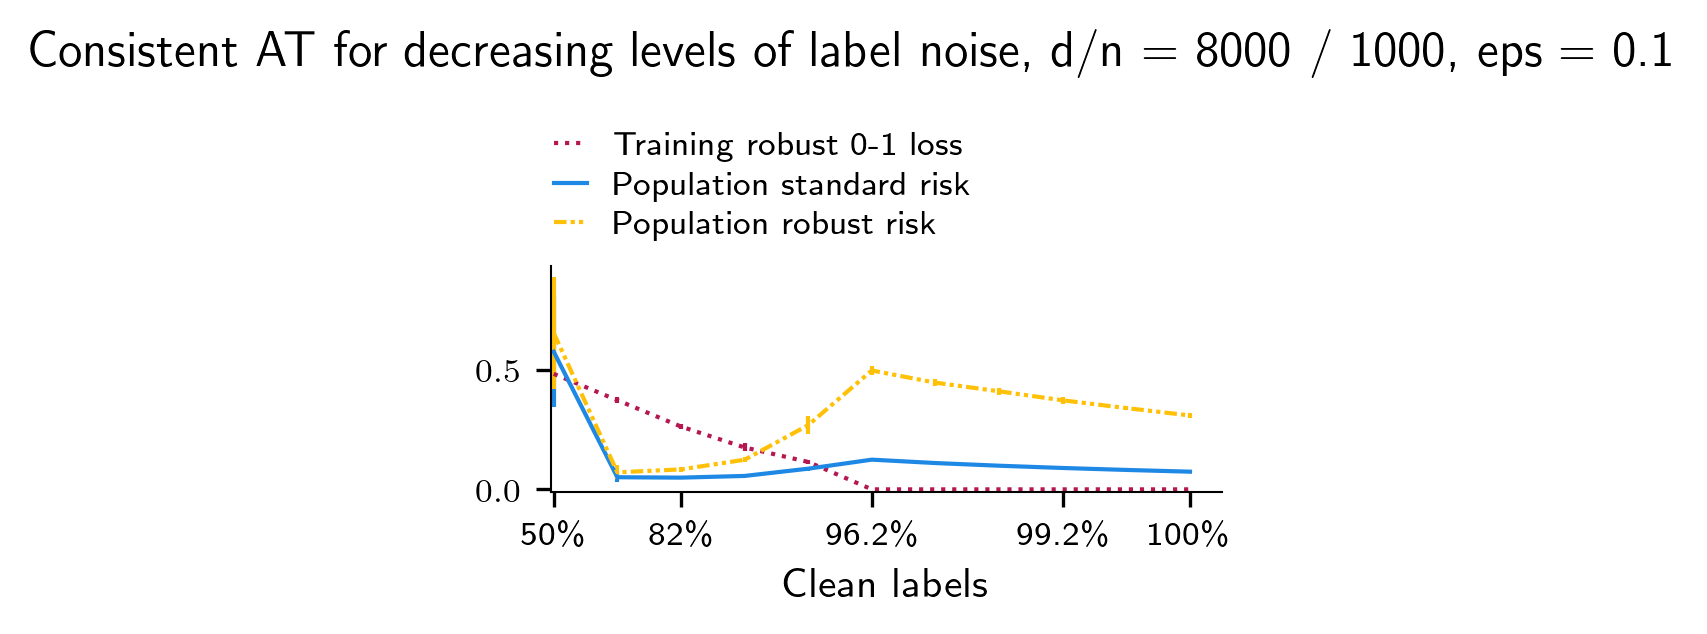

In [12]:
fig, ax = plt.subplots(figsize=FIGURE_SIZE)

x_values = (1.0 - runs_agg['params.label_noise']).astype(np.str)
x_ticks = ('0.5', '0.8200000000000001', '0.962', '0.992', '1.0')
x_tick_labels = (r'50\%', r'82\%', r'96.2\%', r'99.2\%', r'100\%')

ax.errorbar(
    x_values,
    runs_agg[('metrics.train_robust_risk', 'mean')],
    yerr=runs_agg[('metrics.train_robust_risk', 'std')],
    label=fr'Training robust 0-1 loss',
    c=f'C{train_color_idx}',
    ls=ir.plots.LINESTYLE_MAP[train_color_idx]
)
ax.errorbar(
    x_values,
    runs_agg[('metrics.true_std_risk', 'mean')],
    yerr=runs_agg[('metrics.true_std_risk', 'std')],
    label=fr'Population standard risk',
    c=f'C{std_color_idx}',
    ls=ir.plots.LINESTYLE_MAP[std_color_idx]
)
ax.errorbar(
    x_values,
    runs_agg[('metrics.true_robust_risk', 'mean')],
    yerr=runs_agg[('metrics.true_robust_risk', 'std')],
    label=fr'Population robust risk',
    c=f'C{robust_color_idx}',
    ls=ir.plots.LINESTYLE_MAP[robust_linestyle_idx]
)

ax.set_xlabel('Clean labels')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)
ax.set_xlim(left=-0.05)
ax.set_ylim(bottom=-0.01)

if SHOW_TITLES:
    fig.suptitle(f'Consistent AT for decreasing levels of label noise, d/n = {data_dim} / {num_samples}, eps = {train_attack_epsilon}')

legend_loc = (0.0, 1.1)
ir.plots.errorbar_legend(ax, fontsize=LEGEND_FONT_SIZE, loc=legend_loc)

export_fig(fig, f'logreg_noise_increase.pdf')
